In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import os
import random
from typing import List
import matplotlib.pyplot as plt
from google.colab import drive
!pip install gcsfs


<ipython-input-47-794a368ad9bf>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=global_label_counts.index, y=global_label_counts.values, palette='viridis')


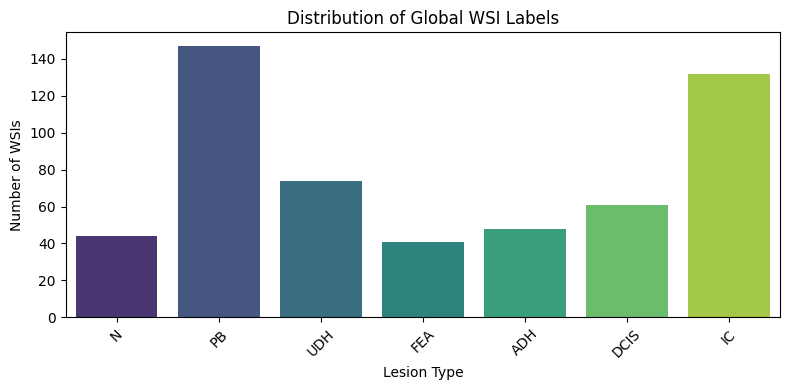

<ipython-input-47-794a368ad9bf>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_series.index, y=region_series.values, palette='mako')


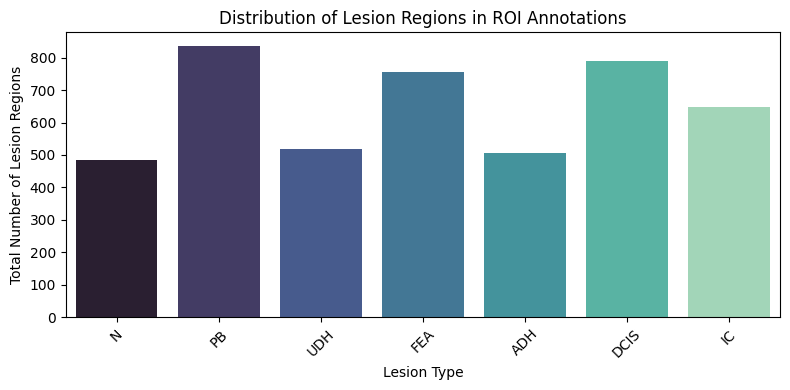

In [47]:
# Reload the data since the session has likely reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load both sheets from the Excel file
xls = pd.ExcelFile("BRACS_BRACS.xlsx")
df_info = pd.read_excel(xls, 'WSI_Information')
df_roi = pd.read_excel(xls, 'WSI_with_RoI_Distribution')

# Set the lesion order
lesions = ['N', 'PB', 'UDH', 'FEA', 'ADH', 'DCIS', 'IC']

# Plot 1: Distribution of global labels (in defined lesion order)
global_label_counts = df_info['WSI label'].value_counts()
global_label_counts = global_label_counts.reindex(lesions).fillna(0)

plt.figure(figsize=(8, 4))
sns.barplot(x=global_label_counts.index, y=global_label_counts.values, palette='viridis')
plt.title("Distribution of Global WSI Labels")
plt.xlabel("Lesion Type")
plt.ylabel("Number of WSIs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Distribution of lesion region counts (in defined lesion order)
lesion_region_counts = {lesion: 0 for lesion in lesions}
for _, row in df_roi.iterrows():
    for lesion in lesions:
        val = row.get(lesion)
        if pd.notna(val) and val != '-' and int(val) > 0:
            lesion_region_counts[lesion] += int(val)

region_series = pd.Series(lesion_region_counts).reindex(lesions)

plt.figure(figsize=(8, 4))
sns.barplot(x=region_series.index, y=region_series.values, palette='mako')
plt.title("Distribution of Lesion Regions in ROI Annotations")
plt.xlabel("Lesion Type")
plt.ylabel("Total Number of Lesion Regions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
import os

# Define a base GCS path for model saving
model_save_dir = 'bracs-dataset-bucket/models/'
fs.mkdirs(model_save_dir, exist_ok=True)  # create dir if needed

best_loss = float('inf')

In [1]:
# Step 1: Install the required library
!pip install -q gcsfs

# Step 2: Authenticate to access Google Cloud Storage
from google.colab import auth
auth.authenticate_user()

# Step 3: Use gcsfs to interact with your bucket
import gcsfs

# Replace with your actual project ID if needed
fs = gcsfs.GCSFileSystem()

# Path to the training embeddings folder
embedding_base_path = 'bracs-dataset-bucket/Embeddings/train'

# Step 4: List WSI folders
wsi_folders = fs.ls(embedding_base_path)

# Only keep directories (some may include .pt files directly)
wsi_dirs = [path for path in wsi_folders if not path.endswith('.pt')]

print(f"✅ Number of WSI folders: {len(wsi_dirs)}\n")

# Print first few folder names
print("📂 Sample WSI Folders:")
for folder in wsi_dirs[:10]:
    print("-", folder)


✅ Number of WSI folders: 72

📂 Sample WSI Folders:
- bracs-dataset-bucket/Embeddings/train/BRACS_1003675
- bracs-dataset-bucket/Embeddings/train/BRACS_1003693
- bracs-dataset-bucket/Embeddings/train/BRACS_1003713
- bracs-dataset-bucket/Embeddings/train/BRACS_1003714
- bracs-dataset-bucket/Embeddings/train/BRACS_1003715
- bracs-dataset-bucket/Embeddings/train/BRACS_1003716
- bracs-dataset-bucket/Embeddings/train/BRACS_1003717
- bracs-dataset-bucket/Embeddings/train/BRACS_1003718
- bracs-dataset-bucket/Embeddings/train/BRACS_1003728
- bracs-dataset-bucket/Embeddings/train/BRACS_1239


In [19]:
import torch
import torch.nn as nn

lesions = ["N", "PB", "UDH", "FEA", "ADH", "DCIS", "IC"]
severity_rank = {i: i for i in range(len(lesions))}

def build_severity_matrix(lesions):
    num_classes = len(lesions)
    M = torch.zeros((num_classes, num_classes), dtype=torch.float32)
    for i in range(num_classes):
        for j in range(num_classes):
            dist = abs(i - j)
            M[i, j] = 1.0 - dist / (num_classes - 1)
    return M

# Define severity-weighted loss
similarity_matrix = build_severity_matrix(lesions).cuda()

import numpy as np
import pandas as pd

# Define lesion classes and severity ranks
lesions = ["N", "PB", "UDH", "FEA", "ADH", "DCIS", "IC"]
severity = {i: rank for i, rank in enumerate(range(len(lesions)))}
num_classes = len(lesions)

# Build severity-aware similarity matrix
M = np.zeros((num_classes, num_classes), dtype=np.float32)
for i in range(num_classes):
    for j in range(num_classes):
        dist = abs(i - j)
        M[i, j] = 1.0 - dist / (num_classes - 1)

# Apply severity-based weighting
W = np.zeros_like(M)
for i in range(num_classes):
    for j in range(num_classes):
        weight = max(severity[i], severity[j]) + 1
        W[i, j] = M[i, j] * weight

# Create and print as pandas DataFrame
df_weighted_similarity = pd.DataFrame(W, index=lesions, columns=lesions)
print("📋 Final Severity-Weighted Similarity Matrix:")
print(df_weighted_similarity.round(2).to_string())




📋 Final Severity-Weighted Similarity Matrix:
         N    PB   UDH   FEA   ADH  DCIS    IC
N     1.00  1.67  2.00  2.00  1.67  1.00  0.00
PB    1.67  2.00  2.50  2.67  2.50  2.00  1.17
UDH   2.00  2.50  3.00  3.33  3.33  3.00  2.33
FEA   2.00  2.67  3.33  4.00  4.17  4.00  3.50
ADH   1.67  2.50  3.33  4.17  5.00  5.00  4.67
DCIS  1.00  2.00  3.00  4.00  5.00  6.00  5.83
IC    0.00  1.17  2.33  3.50  4.67  5.83  7.00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimilarityAggregator(nn.Module):
    def __init__(self, sim_vector_len, hidden_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(sim_vector_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # output: scalar
        )

    def forward(self, sim_vectors):
        """
        sim_vectors: Tensor of shape (B, L) — L = m (row) or n (col)
        Returns: Tensor of shape (B, 1)
        """
        return self.mlp(sim_vectors).squeeze(-1)  # (B,)


In [10]:
class WSISimilarityScorer(nn.Module):
    def __init__(self, max_patches=256, hidden_dim=128):
        super().__init__()
        self.row_mlp = SimilarityAggregator(sim_vector_len=max_patches, hidden_dim=hidden_dim)
        self.col_mlp = SimilarityAggregator(sim_vector_len=max_patches, hidden_dim=hidden_dim)
        self.max_patches = max_patches  # Needed for padding to fixed size

    def forward(self, Q_emb, D_emb):
      """
      Q_emb: (m, d) patch embeddings from query WSI
      D_emb: (n, d) patch embeddings from candidate WSI
      Returns: scalar similarity score
      """
      Q = F.normalize(Q_emb, p=2, dim=1)
      D = F.normalize(D_emb, p=2, dim=1)

      m, d = Q.shape
      n, _ = D.shape

      # Handle truncation
      if m > self.max_patches:
          Q = Q[torch.topk(Q.norm(dim=1), self.max_patches).indices]
          m = self.max_patches
      if n > self.max_patches:
          D = D[torch.topk(D.norm(dim=1), self.max_patches).indices]
          n = self.max_patches

      # Compute similarity
      S = torch.matmul(Q, D.T)  # (m, n)

      # Pad
      S_padded = torch.zeros(self.max_patches, self.max_patches, device=Q.device)
      S_padded[:m, :n] = S

      # Row-wise and column-wise scores
      row_scores = self.row_mlp(S_padded[:m, :])  # (m,)
      col_scores = self.col_mlp(S_padded[:, :n].T)  # (n,)

      sim_score = row_scores.mean() + col_scores.mean()
      return sim_score



In [27]:
class HierarchicalContrastiveLoss(nn.Module):
    def __init__(self, similarity_matrix, severity_dict, margin=0.3):
        super().__init__()
        self.M = similarity_matrix
        self.severity_dict = severity_dict
        self.margin = margin
        self.sigmoid = nn.Sigmoid()

    def forward(self, sim_score, y_q, y_d):
        idx_q = torch.nonzero(y_q).squeeze(1)
        idx_d = torch.nonzero(y_d).squeeze(1)

        if len(idx_q) == 0 or len(idx_d) == 0:
          return torch.tensor(0.0, device=sim_score.device)


        sim_sum, weight_sum = 0.0, 0.0
        for i in idx_q:
            for j in idx_d:
                sim = self.M[i, j]
                weight = max(self.severity_dict[i.item()], self.severity_dict[j.item()]) + 1
                sim_sum += sim * weight
                weight_sum += weight

        shier = sim_sum / weight_sum
        s = self.sigmoid(sim_score)

        pull = shier * (1 - s)**2
        push = (1 - shier) * torch.clamp(s - self.margin, min=0)**2
        return pull + push


In [37]:
import pandas as pd
import torch

# Lesion classes in severity order
lesions = ['N', 'PB', 'UDH', 'FEA', 'ADH', 'DCIS', 'IC']
label2idx = {lesion: i for i, lesion in enumerate(lesions)}

# Load both sheets
xls = pd.ExcelFile("BRACS_BRACS.xlsx")
df_roi = pd.read_excel(xls, 'WSI_with_RoI_Distribution')
df_global = pd.read_excel(xls, 'WSI_Information')

# Build multi-hot label mapping
slide_to_multihot = {}

# 1. First: build from ROI sheet if possible
for _, row in df_roi.iterrows():
    slide_id = str(row['WSI Filename']).strip()
    vec = torch.zeros(len(lesions), dtype=torch.float32)

    valid_label = False
    for lesion in lesions:
        value = row.get(lesion, 0)
        if value != '-' and int(value) > 0:
            vec[label2idx[lesion]] = 1.0
            valid_label = True

    if valid_label:
        slide_to_multihot[slide_id] = vec

# 2. Then: fill in missing WSIs using global label
for _, row in df_global.iterrows():
    slide_id = str(row['WSI Filename']).strip()

    if slide_id not in slide_to_multihot:
        global_label = row.get("Label", "").strip()
        vec = torch.zeros(len(lesions), dtype=torch.float32)
        if global_label in label2idx:
            vec[label2idx[global_label]] = 1.0
        slide_to_multihot[slide_id] = vec



In [38]:
# sanity check
def check_encoding(slide_id):
    row = df[df['WSI Filename'] == slide_id].iloc[0]
    print(f"🧾 Slide: {slide_id}")
    print("Lesions in Excel row:")
    for lesion in lesions:
        print(f"{lesion}: {row[lesion]}")
    print("\nMulti-hot vector:")
    print(slide_to_multihot[slide_id].tolist())

# Example
check_encoding("BRACS_1916")

🧾 Slide: BRACS_1916
Lesions in Excel row:
N: 1
PB: 7
UDH: -
FEA: 1
ADH: -
DCIS: -
IC: -

Multi-hot vector:
[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [39]:
from torch.utils.data import Dataset
import random
import torch

class WSIPairDataset(Dataset):
    def __init__(self, wsi_dirs, slide_to_multihot, fs, max_patches=256):
        self.wsi_dirs = wsi_dirs
        self.slide_to_multihot = slide_to_multihot
        self.fs = fs
        self.max_patches = max_patches

    def __len__(self):
        return len(self.wsi_dirs) * 1  # more variety

    def __getitem__(self, idx):
      q_path, d_path = random.sample(self.wsi_dirs, 2)
      q_id = q_path.split("/")[-1]
      d_id = d_path.split("/")[-1]

      with self.fs.open(self.fs.ls(q_path)[0], 'rb') as f:
          q_data = torch.load(f)
      with self.fs.open(self.fs.ls(d_path)[0], 'rb') as f:
          d_data = torch.load(f)

      q_emb = q_data['embeddings'][:self.max_patches]
      d_emb = d_data['embeddings'][:self.max_patches]

      y_q = self.slide_to_multihot.get(q_id, torch.zeros(7))
      y_d = self.slide_to_multihot.get(d_id, torch.zeros(7))

      return q_emb, d_emb, y_q, y_d, q_id, d_id




In [ ]:
dataset = WSIPairDataset(
    wsi_dirs=wsi_dirs,
    slide_to_multihot=slide_to_multihot,
    fs=fs,
    max_patches=256
)
loss_fn = HierarchicalContrastiveLoss(similarity_matrix.cuda(), severity_rank).cuda()

from torch.utils.data import DataLoader

EPOCHS = 50
max_patches = 256

optimizer = torch.optim.Adam(scorer.parameters(), lr=1e-4)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(EPOCHS):
    print(f"\n🔁 Epoch {epoch + 1}/{EPOCHS}")
    total_loss = 0.0

    num_batches = len(loader)  # total batches in this epoch

    for batch_idx, (q_emb, d_emb, y_q, y_d, q_id, d_id) in enumerate(loader, 1):
        q_emb = q_emb[0].cuda()
        d_emb = d_emb[0].cuda()
        y_q = y_q[0].cuda()
        y_d = y_d[0].cuda()
        q_id = q_id[0]
        d_id = d_id[0]

        # ✅ Print progress
        print(f"[{batch_idx}/{num_batches}] - Pair: {q_id} ↔ {d_id}")

        if y_q.sum() == 0 or y_d.sum() == 0:
            continue

        q_emb = q_emb[:max_patches]
        d_emb = d_emb[:max_patches]

        sim_score = scorer(q_emb, d_emb)
        loss = loss_fn(sim_score, y_q, y_d)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"✅ Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")




🔁 Epoch 1/50
[1/72] - Pair: BRACS_1510 ↔ BRACS_1499
[2/72] - Pair: BRACS_1795 ↔ BRACS_1788
[3/72] - Pair: BRACS_1507 ↔ BRACS_1267
[4/72] - Pair: BRACS_1003728 ↔ BRACS_1378
[5/72] - Pair: BRACS_1933 ↔ BRACS_1003715
[6/72] - Pair: BRACS_1003716 ↔ BRACS_1386
[7/72] - Pair: BRACS_1969 ↔ BRACS_1857
[8/72] - Pair: BRACS_1934 ↔ BRACS_1003675
[9/72] - Pair: BRACS_1899 ↔ BRACS_1257
[10/72] - Pair: BRACS_1003693 ↔ BRACS_1778
[11/72] - Pair: BRACS_1912 ↔ BRACS_1401
[12/72] - Pair: BRACS_1858 ↔ BRACS_1269
[13/72] - Pair: BRACS_1877 ↔ BRACS_1795
[14/72] - Pair: BRACS_1808 ↔ BRACS_1968
[15/72] - Pair: BRACS_1378 ↔ BRACS_1003693
[16/72] - Pair: BRACS_1401 ↔ BRACS_1507
[17/72] - Pair: BRACS_1808 ↔ BRACS_1987
[18/72] - Pair: BRACS_1403 ↔ BRACS_1486
[19/72] - Pair: BRACS_1378 ↔ BRACS_1385
[20/72] - Pair: BRACS_1926 ↔ BRACS_1641
[21/72] - Pair: BRACS_743 ↔ BRACS_1510
[22/72] - Pair: BRACS_1863 ↔ BRACS_1641
[23/72] - Pair: BRACS_1506 ↔ BRACS_1934
[24/72] - Pair: BRACS_1003714 ↔ BRACS_1239
[25/72] - Pair: